In [2]:
import os
from functools import partial
import json
import csv

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

In [70]:
graph_path = "./utah.json"
graph = Graph.from_json(graph_path)

In [72]:
graph.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [42]:
x = "23,532,113"
int(x.replace(",",""))

23532113

In [3]:
def num_feasible_districts(state, num_dists, election):
    graph = Graph.from_json("./"+state+".json")
    
    TOTPOP = "TOTPOP"
    DEMVOTE = election+"D"
    REPVOTE = election+"R"
    
    # Ensure data are integers
    for n in graph.nodes:
        if type(graph.nodes[n][DEMVOTE]) != int:
            graph.nodes[n][DEMVOTE] = int(graph.nodes[n][DEMVOTE].replace(",", ""))
        if type(graph.nodes[n][REPVOTE]) != int:
            graph.nodes[n][REPVOTE] = int(graph.nodes[n][REPVOTE].replace(",", ""))
        
    # Find the ideal population I
    pop_count = 0
    for i in graph.nodes:
        pop_count += graph.nodes[i][TOTPOP]
    pop_count = np.round(pop_count)
    I = pop_count / num_dists
    
    # Create lists of total pop, dem, and rep voters per precinct
    prec_pop = []
    prec_dem = []
    prec_rep = []
    for n in graph.nodes:
        prec_pop.append(graph.nodes[n][TOTPOP])
        prec_rep.append(graph.nodes[n][REPVOTE])
        prec_dem.append(graph.nodes[n][DEMVOTE])
        
    # Create a sorted list of deltas according to a specific, hard-coded metric

    party_list = [1, -1]
    feasible = []
    infeasible = []
    
    for p in party_list: 
        def metric(i):
            if prec_pop[i] == 0:
                return 0
            else:
                return p*((prec_rep[i] - prec_dem[i]) / prec_pop[i])

        deltas = []
        for i in range(len(prec_pop)):
            deltas.append(metric(i))
        ourlist = []
        for i in range(len(prec_pop)):
            ourlist.append((deltas[i], prec_pop[i]))
            ourlist.sort(key=lambda x:x[0], reverse=True)
        d = []
        p = []
        for i in range(len(prec_pop)):
            d.append(ourlist[i][0])
            p.append(ourlist[i][1])

        # Greedily create precincts
        quasi_dist_pop = 0
        k = []
        for i in range(len(prec_pop)):
            if sum(d[:i+1]) > 0:
                quasi_dist_pop += p[i]

        quasi_dist_pop = np.round(quasi_dist_pop)

        districts_k1 = quasi_dist_pop / I
        
        feasible.append(np.floor(districts_k1))
        infeasible.append(np.ceil(districts_k1))
    
    print("Republican situation:")
    if feasible[0] == num_dists:
        print("Feasible to have",feasible[0],"districts")
    else:
        print("Feasible to have",feasible[0],"districts")
        print("Not feasible to have",infeasible[0],"districts")
        
    print("Democratic situation:")
    if feasible[1] == num_dists:
        print("Feasible to have",feasible[1],"districts")
    else:
        print("Feasible to have",feasible[1],"districts")
        print("Not feasible to have",infeasible[1],"districts")

In [108]:
num_feasible_districts("massachusetts", 9, "SEN14")

Republican situation:
Feasible to have 3.0 districts
Not feasible to have 4.0 districts
Democratic situation:
Feasible to have 9.0 districts


In [165]:
def max_partisan_districts(json_name, shp_name, num_dists, election, D):
    graph = Graph.from_json("./"+json_name+".json")
    
    TOTPOP = "TOTPOP"
    DEMVOTE = election+"D"
    REPVOTE = election+"R"
    
    # Ensure data are integers
    for n in graph.nodes:
        if type(graph.nodes[n][DEMVOTE]) != int:
            graph.nodes[n][DEMVOTE] = int(graph.nodes[n][DEMVOTE].replace(",", ""))
        if type(graph.nodes[n][REPVOTE]) != int:
            graph.nodes[n][REPVOTE] = int(graph.nodes[n][REPVOTE].replace(",", ""))
        
    # Find the ideal population I
    pop_count = 0
    for i in graph.nodes:
        pop_count += graph.nodes[i][TOTPOP]
    pop_count = np.round(pop_count)
    I = pop_count / num_dists
    
    # Create lists of total pop, dem, and rep voters per precinct
    prec_pop = []
    prec_dem = []
    prec_rep = []
    for n in graph.nodes:
        prec_pop.append(graph.nodes[n][TOTPOP])
        prec_rep.append(graph.nodes[n][REPVOTE])
        prec_dem.append(graph.nodes[n][DEMVOTE])
        
    # Create a sorted list of deltas according to a specific, hard-coded metric

    vote_shares = []
    deltas = []
    for i in range(len(prec_pop)):
        if prec_pop[i] != 0:
            deltas.append([(prec_rep[i] - prec_dem[i]) / prec_pop[i], i])     
    
  
    dem_deltas = sorted(deltas, reverse = False)
    rep_deltas = sorted(deltas, reverse = True)
    dem_node_list = []
    rep_node_list = []
    dem_vote_shares = []
    rep_vote_shares = [] 

    for i in [1,2]:
        if i == 1:
            party_deltas = rep_deltas
            party_node_list = rep_node_list
            party_vote_shares = rep_vote_shares
        else:
            party_deltas = dem_deltas
            party_node_list = dem_node_list
            party_vote_shares = dem_vote_shares

        # Greedily create precincts
        pop_counter = 0
        for i in range(len(prec_pop)):
            for j in range(D):
                if j*I <= pop_counter < (j+1)*I:
                    party_node_list.append([party_deltas[i][1], j])
                    pop_counter += graph.nodes[party_deltas[i][1]][TOTPOP]
        
        dem_votes = [0 for j in range(D)]
        rep_votes = [0 for j in range(D)]
        total_pop = [0 for j in range(D)]
        ones = [1 for j in range(D)]
        
        for j in range(D):
            for m in range(len(party_node_list)):
                if party_node_list[m][1] == j:
                    dem_votes[j] += graph.nodes[party_node_list[m][0]][DEMVOTE]
                    rep_votes[j] += graph.nodes[party_node_list[m][0]][REPVOTE]
                    total_pop[j] += graph.nodes[party_node_list[m][0]][TOTPOP]
                    
        total_votes = [dem_votes[j] + rep_votes[j] for j in range(D)]
        

        for j in range(D):
            party_vote_shares.append(rep_votes[j] / total_votes[j])
  
    print("For",json_name,":")
    print("The top",D,"most Republican quasi-districts possible are", rep_vote_shares,"Republican")
    print("The top",D,"most Democratic quasi-districts possible are", np.subtract(ones,dem_vote_shares),"Democratic")
    
    
    df = gpd.read_file("./"+shp_name+".shp")
    
        
    color_dict = {}
    
    for n in range(len(graph.nodes)):
        for i in range(len(rep_node_list)):
            if n == rep_node_list[i][0]:
                {n:1/(rep_node_list[i][1]+1)}
            else:
                {n:0}
                
    df["rep_regions"] = df.index.map(color_dict)
    
#     df["rep_regions"] = df.index.map({x:1 if x in rep_node_list else 0 for x in range(len(graph.nodes))})
#     df["dem_regions"] = df.index.map({x:1 if x in dem_node_list else 0 for x in range(len(graph.nodes))})

    plt.figure(figsize=(8,8))
    df.plot(column = "rep_regions", cmap="Set1_r")
    plt.show()
#     plt.figure(figsize=(8,8))
#     df.plot(column = "dem_regions", cmap="tab20c_r")
#     plt.show()

SyntaxError: invalid syntax (<ipython-input-165-0448591ca417>, line 100)

For massachusetts :
The top 2 most Republican quasi-districts possible are [0.5487089422449405, 0.4985101509861911] Republican
The top 2 most Democratic quasi-districts possible are [0.82191157 0.73548537] Democratic


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 576x576 with 0 Axes>

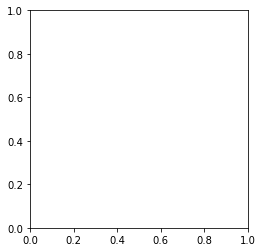

In [166]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14", 2)

For utah :
The most Republican quasi-district possible is 85.79890859102713 % Republican
The most Democratic quasi-district possible is 57.44144195207663 % Democratic


<Figure size 576x576 with 0 Axes>

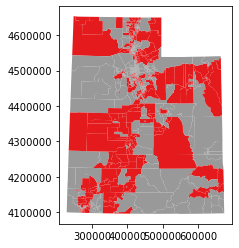

<Figure size 576x576 with 0 Axes>

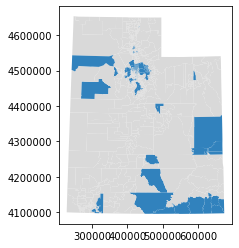

In [127]:
max_partisan_districts("utah", "UT_precincts", 4, "SEN16")

For massachusetts :
The most Republican quasi-district possible is 54.87089422449405 % Republican
The most Democratic quasi-district possible is 82.19115698314639 % Democratic


<Figure size 1008x1008 with 0 Axes>

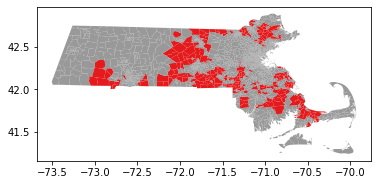

<Figure size 576x576 with 0 Axes>

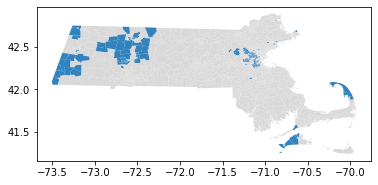

In [124]:
max_partisan_districts("massachusetts", "MA_precincts12_16", 9, "SEN14")

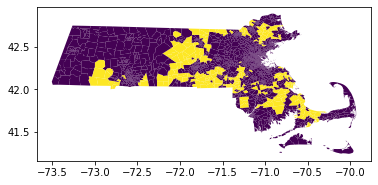

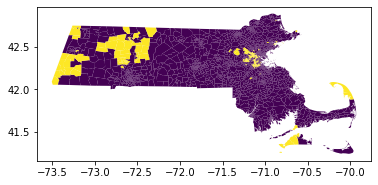

In [93]:
df = gpd.read_file("./MA_precincts12_16.shp")

df["rep_regions"] = df.index.map({x:1 if x in rep_node_list else 0 for x in range(len(graph.nodes))})
df["dem_regions"] = df.index.map({x:1 if x in dem_node_list else 0 for x in range(len(graph.nodes))})

df.plot(column = "rep_regions")
df.plot(column = "dem_regions")

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y

pos = {x: (c_x[x], c_y[x]) for x in graph.nodes}

In [ ]:
# rep_color_map = []
# for node in graph:
#     if node in rep_node_list and node not in dem_node_list:
#         rep_color_map.append('red')
#     else:
#         rep_color_map.append("black")

# # dem_color_map = []
# # for node in graph:
# #     if node in dem_node_list and node not in rep_node_list:
# #         dem_color_map.append('blue')
# #     else:
# #         dem_color_map.append("black")


# plt.figure(1)
# nx.draw_kamada_kawai(graph,
#                     node_size = 10,
#                     node_color = rep_color_map)

# plt.figure(2)
# nx.draw_kamada_kawai(graph,
#                     node_size = 10,
#                     node_color = dem_color_map)

# plt.show()

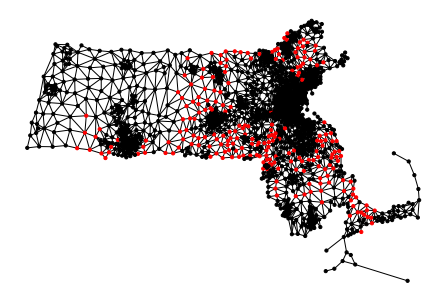

In [85]:
rep_color_map = []
for node in graph:
    if node in rep_node_list and node not in dem_node_list:
        rep_color_map.append('red')
    else:
        rep_color_map.append("black")

nx.draw(graph,
        pos = pos,
        node_size = 10,
        node_color = rep_color_map)

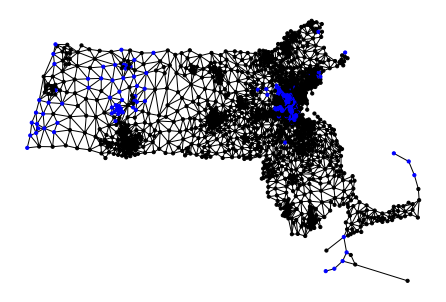

In [87]:
dem_color_map = []
for node in graph:
    if node in dem_node_list and node not in rep_node_list:
        dem_color_map.append('blue')
    else:
        dem_color_map.append("black")

nx.draw(graph,
        pos = pos,
        node_size = 10,
        node_color = dem_color_map)

For massachusetts :
The most Republican quasi-district possible is 54.87089422449405 % Republican
The most Democratic quasi-district possible is 82.19115698314639 % Democratic


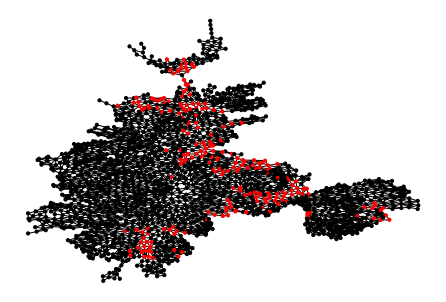

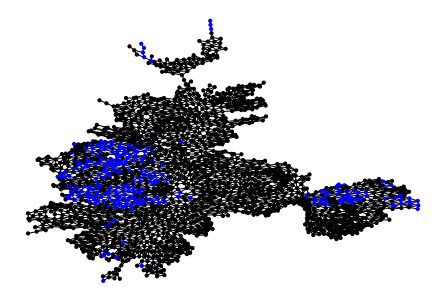

In [53]:
max_partisan_districts("massachusetts", 9, "SEN14")

In [67]:
graph_path = "./massachusetts.json"
plot_path = "./MA_precincts12_16.shp"

df = gpd.read_file(plot_path)

KeyError: ''

In [68]:
centroids = df.centroid

In [ ]:
c_x = centroids.x
c_y = centroids.y
pos = {x: (c_x[x], c_y[y]) for x in graph.nodes}

nx.draw(graph, pos = pos)

In [63]:
unique_label = "Shape_Le_1"

In [66]:
df["plot"] = df[unique_label].map(dict(step.assignment))
df.plot(column="plot", cmap="tab20")
plt.savefig("plot" + ".png")
plt.close()

NameError: name 'step' is not defined

In [61]:
df.columns

Index(['District', 'Name', 'Shape_Le_1', 'Shape_Area', 'City/Town', 'Ward',
       'Pct', 'SEN12D', 'SEN12R', 'PRES12D', 'PRES12R', 'SEN13D', 'SEN13R',
       'SEN14D', 'SEN14R', 'PRES16D', 'PRES16R', 'CD', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'HISP',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')

In [62]:
uniqu

,District,Name,Shape_Le_1,Shape_Area,City/Town,Ward,Pct,SEN12D,SEN12R,PRES12D,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,1-1,Boston Ward 1 Precinct 1,0.237100,0.000684,Boston,1,1,604,251,645,...,1714.474357,502.831622,1071.895298,3.791581e+01,3.000000e+00,4.491581e+01,0.000000e+00,2.691581e+01,27.000001,(POLYGON ((-71.03790871851237 42.3644187404327...
1,1-2,Boston Ward 1 Precinct 2,0.020036,0.000023,Boston,1,2,423,184,464,...,2070.999816,1072.999882,827.999950,4.000000e+01,2.000000e+00,4.200000e+01,0.000000e+00,5.299999e+01,32.999999,"POLYGON ((-71.03011700039906 42.3694850001329,..."
2,1-3,Boston Ward 1 Precinct 3,0.041581,0.000044,Boston,1,3,917,264,959,...,3160.512299,1309.315650,1266.474430,2.096890e+02,5.000000e+00,2.247515e+02,0.000000e+00,5.687509e+01,88.406637,POLYGON ((-71.03392299964656 42.37193199966231...
3,1-4,Boston Ward 1 Precinct 4,0.032658,0.000027,Boston,1,4,264,113,286,...,1870.999990,1191.999972,506.999997,4.300001e+01,6.000000e+00,4.000002e+01,0.000000e+00,5.900000e+01,24.000004,POLYGON ((-71.03808700011473 42.37353599988666...
4,1-5,Boston Ward 1 Precinct 5,0.040514,0.000049,Boston,1,5,440,235,484,...,2887.999711,1663.999810,968.999923,4.700000e+01,9.999997e-01,7.399999e+01,0.000000e+00,9.299999e+01,40.000000,POLYGON ((-71.02592799967721 42.37604599962344...
5,1-6,Boston Ward 1 Precinct 6,0.033327,0.000026,Boston,1,6,384,183,414,...,2520.000556,1490.000363,812.000139,5.900001e+01,5.000001e+00,5.800001e+01,4.691362e-08,6.000002e+01,36.000005,POLYGON ((-71.03451099978264 42.37806900028431...
6,1-7,Boston Ward 1 Precinct 7,0.028062,0.000018,Boston,1,7,508,173,547,...,2387.999802,1450.999860,708.999961,7.600000e+01,5.999999e+00,7.199999e+01,0.000000e+00,4.299999e+01,31.000000,POLYGON ((-71.03319400020274 42.38010299965396...
7,1-8,Boston Ward 1 Precinct 8,0.029680,0.000032,Boston,1,8,675,248,731,...,2709.260983,1571.027932,860.779983,6.828936e+01,4.576402e+00,1.578903e+02,0.000000e+00,7.576403e+00,39.120626,(POLYGON ((-71.03574119230205 42.3841426292790...
8,1-9,Boston Ward 1 Precinct 9,0.036085,0.000034,Boston,1,9,413,164,445,...,2085.912047,1215.999928,733.912115,4.400000e+01,1.000000e+00,3.800001e+01,0.000000e+00,3.000000e+01,22.999997,"POLYGON ((-71.0226640002432 42.38391600012346,..."
9,1-10,Boston Ward 1 Precinct 10,0.033034,0.000034,Boston,1,10,300,95,315,...,1862.000372,1165.000234,552.000121,3.800001e+01,0.000000e+00,6.200000e+01,1.000000e+00,3.800001e+01,6.000004,"POLYGON ((-71.02156199978629 42.3801429996999,..."


In [39]:
graph = Graph.from_json("massachusetts.json")

In [41]:
len(color_map)

2449

In [42]:
len(graph.nodes)

2151

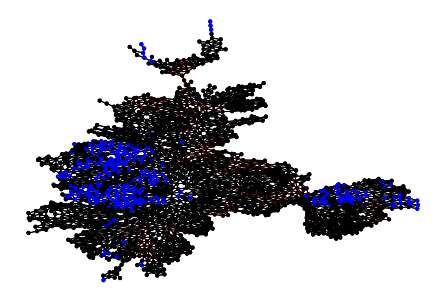

In [49]:
rep_color_map = []
for node in tqdm_notebook(graph):
    if node in rep_node_list and node not in dem_node_list:
        rep_color_map.append('red')
    else:
        rep_color_map.append("black")
        
dem_color_map = []
for node in tqdm_notebook(graph):
    if node in dem_node_list and node not in rep_node_list:
        dem_color_map.append('blue')
    else:
        dem_color_map.append("black")

        
plt.figure(1)
nx.draw_kamada_kawai(graph,
                    node_size = 10,
                    node_color = rep_color_map)

plt.figure(2)
nx.draw_kamada_kawai(graph,
                    node_size = 10,
                    node_color = dem_color_map)

plt.show()

In [25]:
gpd.read_file("MA_precincts12_16.shp")

,District,Name,Shape_Le_1,Shape_Area,City/Town,Ward,Pct,SEN12D,SEN12R,PRES12D,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,1-1,Boston Ward 1 Precinct 1,0.237100,0.000684,Boston,1,1,604,251,645,...,1714.474357,502.831622,1071.895298,3.791581e+01,3.000000e+00,4.491581e+01,0.000000e+00,2.691581e+01,27.000001,(POLYGON ((-71.03790871851237 42.3644187404327...
1,1-2,Boston Ward 1 Precinct 2,0.020036,0.000023,Boston,1,2,423,184,464,...,2070.999816,1072.999882,827.999950,4.000000e+01,2.000000e+00,4.200000e+01,0.000000e+00,5.299999e+01,32.999999,"POLYGON ((-71.03011700039906 42.3694850001329,..."
2,1-3,Boston Ward 1 Precinct 3,0.041581,0.000044,Boston,1,3,917,264,959,...,3160.512299,1309.315650,1266.474430,2.096890e+02,5.000000e+00,2.247515e+02,0.000000e+00,5.687509e+01,88.406637,POLYGON ((-71.03392299964656 42.37193199966231...
3,1-4,Boston Ward 1 Precinct 4,0.032658,0.000027,Boston,1,4,264,113,286,...,1870.999990,1191.999972,506.999997,4.300001e+01,6.000000e+00,4.000002e+01,0.000000e+00,5.900000e+01,24.000004,POLYGON ((-71.03808700011473 42.37353599988666...
4,1-5,Boston Ward 1 Precinct 5,0.040514,0.000049,Boston,1,5,440,235,484,...,2887.999711,1663.999810,968.999923,4.700000e+01,9.999997e-01,7.399999e+01,0.000000e+00,9.299999e+01,40.000000,POLYGON ((-71.02592799967721 42.37604599962344...
5,1-6,Boston Ward 1 Precinct 6,0.033327,0.000026,Boston,1,6,384,183,414,...,2520.000556,1490.000363,812.000139,5.900001e+01,5.000001e+00,5.800001e+01,4.691362e-08,6.000002e+01,36.000005,POLYGON ((-71.03451099978264 42.37806900028431...
6,1-7,Boston Ward 1 Precinct 7,0.028062,0.000018,Boston,1,7,508,173,547,...,2387.999802,1450.999860,708.999961,7.600000e+01,5.999999e+00,7.199999e+01,0.000000e+00,4.299999e+01,31.000000,POLYGON ((-71.03319400020274 42.38010299965396...
7,1-8,Boston Ward 1 Precinct 8,0.029680,0.000032,Boston,1,8,675,248,731,...,2709.260983,1571.027932,860.779983,6.828936e+01,4.576402e+00,1.578903e+02,0.000000e+00,7.576403e+00,39.120626,(POLYGON ((-71.03574119230205 42.3841426292790...
8,1-9,Boston Ward 1 Precinct 9,0.036085,0.000034,Boston,1,9,413,164,445,...,2085.912047,1215.999928,733.912115,4.400000e+01,1.000000e+00,3.800001e+01,0.000000e+00,3.000000e+01,22.999997,"POLYGON ((-71.0226640002432 42.38391600012346,..."
9,1-10,Boston Ward 1 Precinct 10,0.033034,0.000034,Boston,1,10,300,95,315,...,1862.000372,1165.000234,552.000121,3.800001e+01,0.000000e+00,6.200000e+01,1.000000e+00,3.800001e+01,6.000004,"POLYGON ((-71.02156199978629 42.3801429996999,..."


{'boundary_node': True,
 'boundary_perim': 0.14079928066162706,
 'area': 0.0006839594270970608,
 'District': '1-1',
 'Name': 'Boston Ward 1 Precinct 1',
 'Shape_Le_1': 0.2370997653,
 'Shape_Area': 0.00068395943,
 'City/Town': 'Boston',
 'Ward': '1',
 'Pct': '1',
 'SEN12D': '604',
 'SEN12R': '251',
 'PRES12D': '645',
 'PRES12R': '188',
 'SEN13D': '241',
 'SEN13R': '84',
 'SEN14D': '439',
 'SEN14R': '109',
 'PRES16D': '755',
 'PRES16R': '189',
 'CD': '07',
 'TOTPOP': 2127.1376074597397,
 'NH_WHITE': 1232.8953012907173,
 'NH_BLACK': 58.91581379295309,
 'NH_AMIN': 11.999999891822892,
 'NH_ASIAN': 66.91581078543187,
 'NH_NHPI': 1.000000016734194,
 'NH_OTHER': 44.747434355389224,
 'HISP': 710.6632473266911,
 'H_WHITE': 428.83162612047374,
 'H_BLACK': 37.00000046135009,
 'H_AMIN': 4.999999662849095,
 'H_ASIAN': 5.999999756691586,
 'H_NHPI': 4.999999786413395,
 'H_OTHER': 228.83162153891337,
 'VAP': 1714.474357046681,
 'HVAP': 502.8316220818222,
 'WVAP': 1071.8952982689327,
 'BVAP': 37.9158133

/miniconda3/envs/VRDI/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


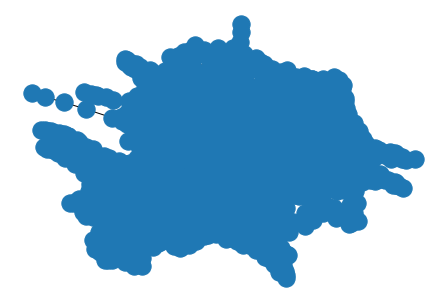

In [23]:
nx.Graph(graph)
nx.draw(graph)

In [136]:
from operator import itemgetter

deltas = [2,3,-5,9]
prec_pop = [100,130,70,96]
ourlist = []
for i in range(len(deltas)):
    ourlist.append((deltas[i], prec_pop[i]))
ourlist.sort(key=lambda x:x[0], reverse=True)
print(ourlist)

# test = zip(deltas, prec_pop)
# sorted(test, reverse=True)
# d = []
# p = []
# for i in test:
#     d.append(i[0])
#     p.append(i[1])
# print(d)
# print(p)

[(9, 96), (3, 130), (2, 100), (-5, 70)]


In [56]:
ascending_DPC = []

for i in range(len(pop_prec)):
    if pop_prec[i] != 0:
        ascending_DPC.append([(dems_prec[i] - reps_prec[i]) / pop_prec[i], i])

In [57]:
len(ascending_DPC)

2151

In [58]:
ascending_DPC[:10]

[[0.15513805916585297, 0],
 [0.08476434853983664, 1],
 [0.11658429409694146, 2],
 [0.05704169941933123, 3],
 [0.06030021301432776, 4],
 [0.05507495868539885, 5],
 [0.06986900144351958, 6],
 [0.08094972551527486, 7],
 [0.07970010748071214, 8],
 [0.0536413364003675, 9]]

In [59]:
ascending_DPC.sort()

In [60]:
ascending_DPC[:10]

[[-0.11742222308712807, 2139],
 [-0.09979575425162523, 483],
 [-0.09854153577032118, 1146],
 [-0.09803887865351182, 600],
 [-0.09737363694990964, 1794],
 [-0.09672432397490777, 2092],
 [-0.09361270636404077, 1157],
 [-0.09277138802468476, 594],
 [-0.0924794033033475, 319],
 [-0.0921568644249277, 1676]]

In [61]:
descending_DPC = ascending_DPC.copy()
descending_DPC.reverse()

In [62]:
descending_DPC[:10]

[[0.5145762918354982, 194],
 [0.45074265408756103, 2030],
 [0.4334006335789255, 196],
 [0.41915852539265136, 2116],
 [0.4124343177682886, 98],
 [0.40581159674896566, 199],
 [0.3867488296432796, 1473],
 [0.3843283622066546, 198],
 [0.3756281370644132, 1447],
 [0.3642433146318682, 2057]]

In [17]:
ascending_DPC[:10]

[[-4.714285714285714, 7829],
 [-3.227777777777778, 6022],
 [-1.9898477157360406, 6023],
 [-1.0338983050847457, 8628],
 [-1.0, 4560],
 [-1.0, 4599],
 [-1.0, 4943],
 [-0.8571428571428571, 5060],
 [-0.8333333333333334, 4709],
 [-0.8085106382978723, 5288]]

In [65]:
I = pop_count/10
print(I)

672816.9714491896


In [66]:
pop_counter = 0
dem_qdist_1 = []
dem_qdist_2 = []

for j in descending_DPC:
    if pop_counter <= I:
        dem_qdist_1.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    elif pop_counter > I and pop_counter <= 2*I:
        dem_qdist_2.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    else:
        break

In [67]:
dem_votes_qdist_1 = 0
rep_votes_qdist_1 = 0
total_pop_qdist_1 = 0
dem_votes_qdist_2 = 0
rep_votes_qdist_2 = 0
total_pop_qdist_2 = 0

for n in dem_qdist_1:
    dem_votes_qdist_1 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_1 += graph.nodes[n][REPVOTE]
    total_pop_qdist_1 += graph.nodes[n][TOTPOP]
    
for n in dem_qdist_2:
    dem_votes_qdist_2 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_2 += graph.nodes[n][REPVOTE]
    total_pop_qdist_2 += graph.nodes[n][TOTPOP]
    
votes_qdist_1 = rep_votes_qdist_1 + dem_votes_qdist_1
votes_qdist_2 = rep_votes_qdist_2 + dem_votes_qdist_2

rep_vs_qdist_1 = rep_votes_qdist_1 / votes_qdist_1
rep_vs_qdist_2 = rep_votes_qdist_2 / votes_qdist_2

print(rep_vs_qdist_1, rep_vs_qdist_2)

overall_rep_vs = (rep_votes_qdist_1 + rep_votes_qdist_2) / (votes_qdist_1 + votes_qdist_2)
print(overall_rep_vs)

0.16982165985852346 0.2582378723219999
0.21077508306610301


In [68]:
pop_counter = 0
rep_qdist_1 = []
rep_qdist_2 = []

for j in ascending_DPC:
    if pop_counter <= I:
        rep_qdist_1.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    elif pop_counter > I and pop_counter <= 2*I:
        rep_qdist_2.append(j[1])
        pop_counter += graph.nodes[j[1]][TOTPOP]
    else:
        break

In [69]:
dem_votes_qdist_1 = 0
rep_votes_qdist_1 = 0
total_pop_qdist_1 = 0
dem_votes_qdist_2 = 0
rep_votes_qdist_2 = 0
total_pop_qdist_2 = 0

for n in rep_qdist_1:
    dem_votes_qdist_1 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_1 += graph.nodes[n][REPVOTE]
    total_pop_qdist_1 += graph.nodes[n][TOTPOP]
    
for n in rep_qdist_2:
    dem_votes_qdist_2 += graph.nodes[n][DEMVOTE]
    rep_votes_qdist_2 += graph.nodes[n][REPVOTE]
    total_pop_qdist_2 += graph.nodes[n][TOTPOP]
    
votes_qdist_1 = rep_votes_qdist_1 + dem_votes_qdist_1
votes_qdist_2 = rep_votes_qdist_2 + dem_votes_qdist_2

rep_vs_qdist_1 = rep_votes_qdist_1 / votes_qdist_1
rep_vs_qdist_2 = rep_votes_qdist_2 / votes_qdist_2

print(rep_vs_qdist_1, rep_vs_qdist_2)

overall_rep_vs = (rep_votes_qdist_1 + rep_votes_qdist_2) / (votes_qdist_1 + votes_qdist_2)
print(overall_rep_vs)

0.5518776477346162 0.5037030633122965
0.5288205390920555


CPU times: user 120 ms, sys: 4.23 ms, total: 125 ms
Wall time: 133 ms


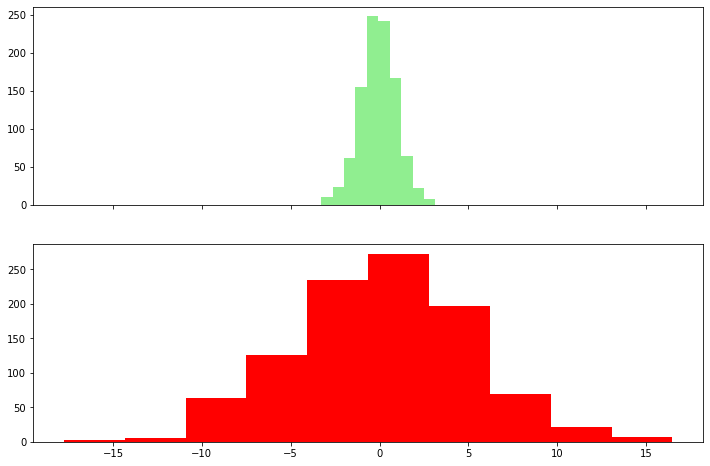

In [101]:
%%time
all_plans = []
outliers = []

colors = ["lightgreen", "red"]

a = np.random.normal(0, 1, 1000)
o = list(np.random.normal(0, 5, 1000))

# for plan in data:
#     all_plans.append(plan)
#     if sorted(plan[3])[-1] > 0.5:
#         outliers.append(plan)
        
fig, pg_compare = plt.subplots(2,1, figsize=(12,8), sharex="col")

pg_compare[0].hist(a, color=colors[0])
pg_compare[1].hist(o, color=colors[1])